## UFO Spottings in the US
by Joseph Cahill
### Introduction
Ever since the idea of aliens permeated pop culture, reports of unidentified flying objects (UFOs) have steadily trickled in. By now, enough reports have come in that it is undeniable that at least some people truly believe that aliens have visited Earth.This leaves us with the question, did these people really see an alien space craft? Or do other factors, such as pop culture fads, human fixations, and local culture explain the sightings? 

In this tutorial, we will collect, curate, and analyze reported UFO sightings to try to find some reasons behind the UFO sightings and learn more about them in general.
### Requirements
The dataset - https://www.kaggle.com/NUFORC/ufo-sightings
Python 3.6 and the following libraries:
* Pandas
* SKLearn
* matplotlib
* folium
* numpy

I suggest using Anaconda to set up the devlopment environment. An alternative is Docker, but Docker is not compatible with Windows 7 and does not have an easy user interface. Only those experienced with using command prompts should use Docker.
### Part 1: Collecting & Parsing the data
The data that we will be using can be found at https://www.kaggle.com/NUFORC/ufo-sightings . It requires an account to download and is stored in a .zip file. There are two datasets in the file. We will use the dataset entitled "scrubbed.csv" where reportings with incomplete data are removed. We will then use Pandas to parse the data into a more easily manipulated form, a dataframe.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn
import warnings
import math
warnings.filterwarnings("ignore")
#load the data into the sightings dataframe
sightings = pd.read_csv("scrubbed.csv")
#display the first few values
sightings.head()

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


### Tidying the Data
As we can see, Pandas loaded the csv file quite easily. However the current dataframe we have is not perfect. The comments section is far too verbose to perform meaningful analysis, and really is just cluttering the data frame. Likewise, the duration (hours/min) column is unnecessary, due to its equivalent being standardized in the duration (seconds) column. To address this, we will drop both columns.

In [2]:
#drop the columns
sightings = sightings.drop(['comments','duration (hours/min)'],axis=1)
sightings.head()

,datetime,city,state,country,shape,duration (seconds),date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,1/22/2004,21.4180556,-157.803611


Now the dataframe looks much cleaner. Still, more tidying is needed. In order to correctly handle the datetime column, it must be converted from an object type into a datetime type. Additionally some of the times are recorded as 24:00 hours rather than 00:00 hours. This would cause the datetime conversion to break, so we must replace each record of 24:00 hours with one of 00:00 hours before the conversion.

In [3]:
#split datetime column into two columns, date and time 
sightings['date'],sightings['time'] = sightings['datetime'].str.split(' ',1).str
#replace 24:00 hours records with 00:00 hours records
sightings['time'].replace('24:00','00:00',inplace=True)
#convert & combine the two columns into a date time object
sightings['datetime']=pd.to_datetime(sightings['date'] +' '+ sightings['time'])

sightings.head()

,datetime,city,state,country,shape,duration (seconds),date posted,latitude,longitude,date,time
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,4/27/2004,29.8830556,-97.941111,10/10/1949,20:30
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,12/16/2005,29.38421,-98.581082,10/10/1949,21:00
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,1/21/2008,53.2,-2.916667,10/10/1955,17:00
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/17/2004,28.9783333,-96.645833,10/10/1956,21:00
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,1/22/2004,21.4180556,-157.803611,10/10/1960,20:00


Now the date time column is of the correct data  type, yet the duration (in seconds) and the latitude are still stored as strings rather than integers or floats. Upon further examination, this is due to dirty data that includes characters by accident. In order to convert these values we must first use a [regular expression](https://www.tutorialspoint.com/python/python_reg_expressions.htm) to remove any irrelevant characters from the columns.  

In [4]:
# remove all characters from the latitude column using regular expressions
# the regular expression ('[^-0123456789.]+') matches all characters except for digits,'-', and '.'
sightings['latitude'].replace(to_replace='[^-0123456789.]+', value='',inplace=True,regex=True)
#convert values in the latitude column to floats
sightings['latitude']=pd.to_numeric(sightings['latitude'])

# remove all characters from the duration column using regular expressions
sightings['duration (seconds)'].replace(to_replace='[^-0123456789.]+', value='',inplace=True,regex=True)
# convert values in the duration column to floats
sightings['duration (seconds)'] = pd.to_numeric(sightings['duration (seconds)'])

sightings.head()

,datetime,city,state,country,shape,duration (seconds),date posted,latitude,longitude,date,time
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,4/27/2004,29.883056,-97.941111,10/10/1949,20:30
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200.0,12/16/2005,29.384210,-98.581082,10/10/1949,21:00
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,1/21/2008,53.200000,-2.916667,10/10/1955,17:00
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/17/2004,28.978333,-96.645833,10/10/1956,21:00
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,1/22/2004,21.418056,-157.803611,10/10/1960,20:00


### Part 2: Exploratory Data Analysis
Now that the data is both readable and usable, we can begin to explore the relationships between location, duration ,date, time of day, and UFO sightings. It is our hope that in doing so, some trends that we can analyze will make themselves apparent.
##### UFO Sightings by Time of Day 
First we will analyze UFO sightings by the time of day at which they were spotted to find see if there are any times in which it is more likely to see a UFO.  To visualize this data, we will create a graph that compares the hour in which the UFO was spotted  and the number of sigthings that occured at that hour.  While the time data we currently have is more precise, we will analyze it by hour because it increases readability. Reducing the precision of a metric inorder to view the data more generally is referred to as "binning" and is frequently used in statistical analysis.

First we will create a separate column that stores hours alone to bin the data. We will use panda's apply() which applys the lambda function to each value in the series it is called on. Next we will use pandas group_by() function along with  to count the number of sightings for each hour.

In [5]:
#put each hour value from the datetime column into their respective row's (newly created) 'hour' column. 
sightings['hour'] = sightings['datetime'].apply(lambda t : t.hour)
#group the dataframe by hour and storing each hour's respective number of sightings. 
sightings_by_hour = sightings.groupby(sightings['hour']).size()
#name the column that stores the number of sightings
sightings_by_hour = sightings_by_hour.reset_index(name='number of sightings')

sightings_by_hour.head()

,hour,number of sightings
0,0,4802
1,1,3210
2,2,2357
3,3,2004
4,4,1529


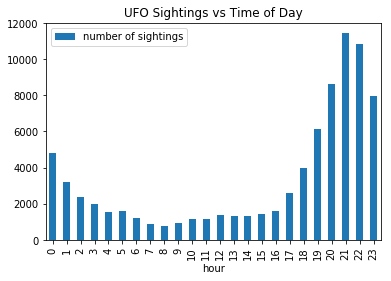

In [6]:
#the below line allows me to display the plot in this notebook and is not always necessary in other python environments.
%matplotlib inline
#plot the sightings by hour with a bar chart
sightings_by_hour.plot('hour','number of sightings',kind="bar",title="UFO Sightings vs Time of Day")

Now we can start to see a few trends. At first it appears that the distribution is the inverse of the normal distribution. However when considering that time of day is cyclical and that 0:00 hours is actually closer to 23:00 hours than 21:00 hours is, the distribution closely resembles the normal distribution. 

##### UFO Sightings by Time of Day - Finding the Mean

There is another way to compare UFO sightings and time of day that may prove to be illuminating. We can take the average number of UFO sightings per hour in a day. In other words the metric would tell us the average number of UFO sightings that occured in a certain hour of the day. However, first we must determine the range of dates for this dataset.

In the description of the dataset, the author links to its [original source](https://github.com/planetsig/ufo-reports). Here the original author states that the data was collected over the 20th and 21st centuries. You can also see that he posted the dataset on 6/21/2014. With this info, we can assume that the data set starts in 1900 and ends in june 2014. It is important to note that such an assumption could skew the data, however with the latest report occuring on 5/8/2014,the earliest report occuring on 11/11/1906, and a total time period of about 108 years, the margin by which the data could be skewed should be small. Using an [online calculator](https://www.timeanddate.com/date/durationresult.html?m1=1&d1=1&y1=1900&m2=6&d2=1&y2=2014), we find that the data has been collected over a period of 41,789 days. To find the mean (average), we simply divide the number of sightings per hour by this number.

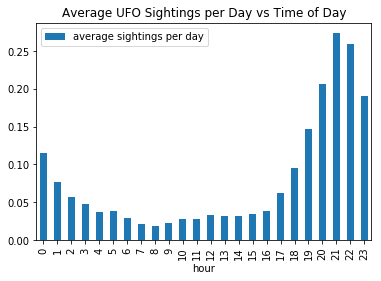

In [7]:
DAYS = 41789.0
sightings_by_hour['average sightings per day'] = sightings_by_hour['number of sightings'].apply(lambda t: t/DAYS)
sightings_by_hour.plot('hour','average sightings per day',kind="bar",title="Average UFO Sightings per Day vs Time of Day")
#3117+2460+1952+1684+1299+1044+804+745+859+1050+1016+1191+1165+1166+1279+1393+1972+2618+3513+4494+5062+4979+4275

Now the data is a little bit easier to interpret. Again, we see the standard distribution We can see that about every 4 days, someone reports a UFO sighting that occured at 21:00 hours. Additionally you can see that about every 20 days, someone reports one that occured at 3:00 hours and that at 8:00 hours, it takes about 40 days for a report to come in. 

##### UFO Sightings by Time of Day - Finding the Standard Deviation

Now that we have the mean, we can compute the standard deviation. This will measure how reliably reports come in, with a higher value meaning that the reports come in waves and a lower value indicating that the reports steadily come in.This process is complicated by the fact that the dataset does not keep track of days where no UFO sightings occured. In order to calculate the standard deviation, you must account for every day.

We will do this by grouping the sightings by hour and date. Next we will count the number of unique dates and subtract it from the total number of days in the time period, giving us the number of days where no sighting occured at the respective hour. 

In [8]:
sightings_by_hour_date = sightings.groupby(['hour','date']).size()
sightings_by_hour_date = sightings_by_hour_date.reset_index(name="number of sightings")

# replace the date column with datetime objects rather than strings
sightings['date'] = sightings['datetime'].apply(lambda t:t.date())

unique_dates_by_hour = sightings.groupby(['hour']).date.nunique()
unique_dates_by_hour = unique_dates_by_hour.reset_index(name='unique dates')
#
unique_dates_by_hour['no sightings'] = unique_dates_by_hour.apply(lambda t: DAYS-t['unique dates'],axis=1)

unique_dates_by_hour.head()

,hour,unique dates,no sightings
0,0,3117,38672.0
1,1,2460,39329.0
2,2,1952,39837.0
3,3,1684,40105.0
4,4,1299,40490.0


Now that we have all of the data we need, we must synthesize it so that the relevant data is all in the same dataframe.  To do this we will use the pandas join() function to combine the  average sightings per day for each hour and the sightings that were grouped by hour and date. When used in the manner below, join() combines each row that shares the same index. So we must set the index to a meaningful identifier that both dataframes have. We will use the hour column for this purpose. Because of the fact that each dataframe has the exact same set of unique indexes(in this case hours), any type of join would work other than an outer join. Here we use a left join.

In [9]:
#set hour as the index
sightings_by_hour = sightings_by_hour.set_index('hour')
sightings_by_hour_date = sightings_by_hour_date.set_index('hour')

#combine the average sightings per day for each hour with the sightings grouped
#by hour and date
bar = sightings_by_hour_date.join(sightings_by_hour.drop('number of sightings',axis=1))

bar.head()

,date,number of sightings,average sightings per day
hour,,,
0,1/1/1910,1,0.114911
0,1/1/1953,1,0.114911
0,1/1/1968,2,0.114911
0,1/1/1978,1,0.114911
0,1/1/1981,1,0.114911


Now we are ready to perform the first part of our calculation of the standard deviation. We will use apply() and a labmda function to sum up the variances of each hour, day pair that had at least one sighting.

In [10]:
#calculate the variance for all (day,hour) pairs that have sightings
sightings_variance = bar.apply(lambda t:(t['number of sightings'] - t['average sightings per day'])**2,axis=1)
#sum the individual variances for each hour
sightings_variance = sightings_variance.groupby('hour').agg('sum').reset_index(name='variance')
sightings_variance.head()

,hour,variance
0,0,17359.556657
1,1,5157.366225
2,2,3149.328837
3,3,2599.668242
4,4,2200.851137


Next we will apply a function that calculates the partial variances of the day, hour pairs that had no sightings, adding them them to partial variance we calculated previously. Finally we divide this number by the total number of days (leaving us with the variance) and take the square root to get the standard deviation.

In [11]:

#extract the average sightings per day column and prepare it for a join
average_column= sightings_by_hour['average sightings per day'].reset_index(name='average sightings').set_index('hour')
#prepare unique_dates for a join by setting its index to hour
unique_dates_by_hour = unique_dates_by_hour.set_index('hour')
#combine all of the data needed to calculate the variance 
std_dev_by_hour = sightings_variance.join(unique_dates_by_hour).join(average_column)
#add the sum of the partial variances from day hour pairs with no UFO sightings
#to the partial variances from pairs that do have UFO sightings
std_dev_by_hour['standard deviation'] = std_dev_by_hour.set_index('hour').apply(lambda t: ( (t['average sightings'] ** 2) * t['no sightings'] ) + t['variance'] , axis=1)
#divide the previous sums by the total number of days and then take the square root, giving us the actual standard deviation
std_dev_by_hour['standard deviation'] = std_dev_by_hour.apply(lambda t: math.sqrt(t['standard deviation']/DAYS) , axis=1 )
std_dev_by_hour

,hour,variance,unique dates,no sightings,average sightings,standard deviation
0,0,17359.556657,3117,38672.0,0.114911,0.653934
1,1,5157.366225,2460,39329.0,0.076814,0.359121
2,2,3149.328837,1952,39837.0,0.056402,0.279992
3,3,2599.668242,1684,40105.0,0.047955,0.253804
4,4,2200.851137,1299,40490.0,0.036589,0.232299
5,5,2539.747235,1306,40483.0,0.038072,0.249359
6,6,1647.193721,1044,40745.0,0.029290,0.200632
7,7,1360.178962,804,40985.0,0.021656,0.181683
8,8,894.414856,745,41044.0,0.019216,0.147532
9,9,1162.527728,859,40930.0,0.022925,0.168326


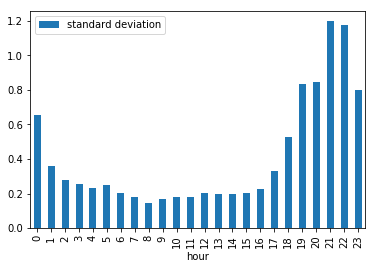

In [12]:
std_dev_by_hour.plot('hour','standard deviation',kind='bar')

What is immediately noticeable about this plot is just how closely it resembles the other plots. It is another standard distribution. The standard deviations is highest for the hours with the most sightings. This could possibly be explained by people mistaking a shooting star for a UFO. Meteor showers occur infrequently and garner the attention of many stargazing parties. It could also be that one reported UFO sighting could encourage others who were unsure to report their own sighting as well. We cannot conclude definitively either way, but it is clear that UFO sightings are not a steady occurence. This is evidenced by just how much larger the standard deviations are than their respective means.

##### UFO Sightings by Location

Another interesting aspect of UFO sightings is the location at which they occured. Hot spots such as Area 51 are well known to alien enthusiasts. So what are the locations that UFO's seem to appear the most? We will map each sighting by its location on a map using [folium](https://folium.readthedocs.io/en/latest/) to get a better idea. Folium is fairly memory intensive so for the sake of making this tutorial accessible to all, we will only map 1000 randomly sampled UFO sightings.

In [94]:

map_sightings = folium.Map(location=[0, 0], zoom_start=2)
sample = sightings.sample(1000)
for iter, row in sample.iterrows():
    folium.CircleMarker(location=[ row['latitude'] , row['longitude '] ], radius=1,color='#3186cc',fill_color='#3186cc').add_to(map_sightings)
map_sightings

It is immediately noticeable that the reports are concentrated on the coasts of the United States and in the United Kingdom. There are very few reported UFO sightings in non-english speaking countries, which leads one to believe that the dataset is incomplete on world wide scale. This could be due to a variety of factors such as language barriers and non-transparent governments. Although it could also be explained by viewing UFO sightings as a cultural phenomenon originating in english speaking countries. Either way, I will mostly focus on analyzing the UFO sightings in the US and UK. 

Surprisingly, there are very few UFO sightings in Nevada where Area 51 is located. There are far more sightings in areas of high population density. This is almost certainly partly due to the fact that there are more people to make reports. However a few other factors may explain this phenomenon. Light polution and increased air traffic could cause more people to mistakenly report a UFO sighting. Also, a higher population density would mean that there would likely be more mentally unsound people living in those areas. 

##### UFO Sightings over Time
The idea of UFO sightings being a cultural phenomenon is an intriguing proposition. To shed a bit of light on this theory, we can examine the historical distribution of UFO sightings. We will bin the data into separate years to improve the graphs readability.

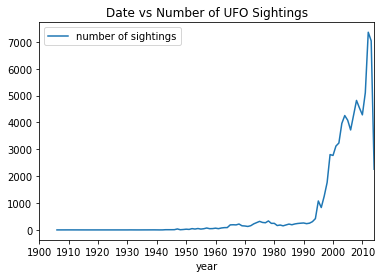

In [13]:

sightings['year'] = sightings.apply(lambda t: t['date'].year,axis=1)
#groupby the date column to count the number of sightings for each date
sightings_by_date =sightings.groupby('year').size().reset_index(name="number of sightings")
#plot the data
sightings_by_date.plot('year','number of sightings',title='Date vs Number of UFO Sightings',kind='line',xticks=[1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010])

We can clearly see that from 1906 until about 1950 remains fairly constant. However between 1950 and the late 1970s, the number of sightings begins to increase. After that, a little after 1990 the number of sightings seem to grow exponentially. We should disregard the dramatic drop in 2014 because the dataset was only published in june 2014, leaving half a years worth of UFO sightings out.

This could be explained by increased transparency efforts in many governments. It could also be due to the invention of the personal computer easing the data gathering and storing of the reports. Additionally, it could be due to aliens becoming more prominent in pop culture. Of course, it could also be due to a increase in the number of extraterrestial visits. 

##### Machine Learning - Predicting the Number of UFO Spottings in Future Years

With the data we collected it is possible to estimate just how many UFO spottings will be reported in the future. This is a regression problem as we are predicting a continuous value.  The distribution does not seem to fit a linear distribution, so linear regression would likely be innaccurate. We will use a least squares polynomial for predictions. To be specific, we will use numpy's [polyfit() function](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html). The polyfit function creates a line of best fit modeled by a function with a specified degree (i.e. quadractic, linear, etc.).

However, before we can create and train our predictor we must first split our data into training and test data. This is a fundamental aspect of machine learning, we want to be able to both train our predictor and test it on some data. One might try to argue that we should test the predictor on all of the data. Yet this is a poor move due to one danger of machine learning, overfitting.
##### Machine Learning - Overfitting
Overfitting occurs when a machine learning algorithm over analyzes the data it trained on. It then expects all of the real or test data to mirror the training data closer than it actually does. This results in innaccuracy in real world situations. 

##### Potential Pitfall
In order to give accurate data, we must ignore the year 2014. This is due to the fact that not all of the reported UFO sightings of that year are in the dataset. 

We will split the data into training and test data quite easily using sklearn's [train_test_split() function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). We will also switch to using the [matplotlib.pyplot library](https://matplotlib.org/api/pyplot_api.html) to display the results so that we can graph the results of the predictor on the same plot as our dataset.

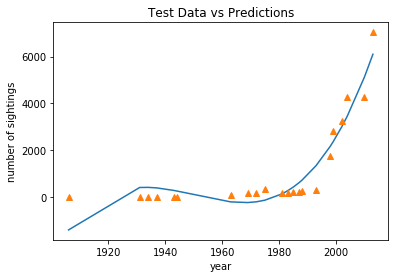

In [105]:

#remove the year 2014
sightings_by_year_no_2014 = sightings_by_date[sightings_by_date['year'] < 2014]
#split the data into training and test data
train, test = train_test_split( sightings_by_year_no_2014,test_size = (.25) )
test = test.sort_values('year')
train = train.sort_values('year')
#train the polyfit predictor
predictor = np.polyfit(train['year'],train['number of sightings'], 3)
polynomial = np.poly1d(predictor)

#create dummy x values to test on
x_vals = np.linspace(1900,2013,200)
predictions = polynomial(test['year'])
plt.plot(test['year'],predictions)
plt.plot(test['year'], test['number of sightings'], '^')
plt.title('Test Data vs Predictions')
plt.xlabel('year')
plt.ylabel('number of sightings')
plt.show()

On the surface, our predictor seems to do a decent job. But it is quite possible that a different degree polynomial would produce a superior result. To find the right degree to choose, we must analyze the effects of choosing a different degree. We will do this using cross validation.
##### Machine Learning - Cross Validation
Cross validation is the process of testing your predictor multiple times with multiple training and test sets. It involves analyzing the accuracy of each test's performance. We will do so by finding the squared error of our predictions using a subsection of the training data and comparing it to the squared error of our predictions using the a different subsection of the training data (validation data).

In order to accomplish this we will use sklearn's [KFold() function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). In short KFolds creates the indexes that you split your dataset along in order to cross validate. 

In [114]:
train = train.reset_index()

Degree with minimum error 4


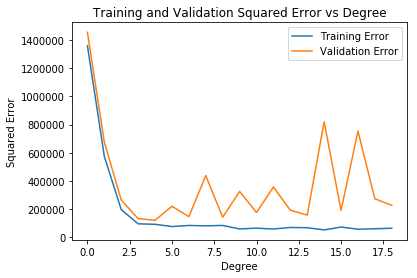

In [116]:

warnings.filterwarnings("ignore")
train_x = train['year']
train_y = train['number of sightings']
KFOLDS = 3
kf = KFold(KFOLDS,shuffle=True)

validation_errors = []
training_errors = []
#start at degree two because the distribution is clearly non-linear
for degree in range(1,20):
    avg_train_error = 0
    avg_validation_error = 0
    for train_index, test_index in kf.split(train_x):
        train_y_cv, test_y_cv = train_y[train_index].dropna(), train_y[test_index].dropna()
        train_x_cv, test_x_cv = train_x[train_index].dropna(), train_x[test_index].dropna()
        #train the predictor
        fit_cv = np.polyfit(train_x_cv, train_y_cv, degree)
        polynomial_cv = np.poly1d(fit_cv)
        
        #test the polynomial on the training data
        train_predictions_cv = polynomial_cv(train_x_cv)
        #find the total squared error
        train_error = (train_predictions_cv - train_y_cv) ** 2
        avg_train_error += np.mean(train_error)/KFOLDS
        
        #do the same for the validation data
        validation_predictions_cv = polynomial_cv(test_x_cv)
        validation_error = (validation_predictions_cv - test_y_cv) ** 2
        avg_validation_error += np.mean(validation_error)/KFOLDS
    #divide by the number of folds to find the average error for a single validation
    validation_errors.append(avg_validation_error)
    training_errors.append(avg_train_error)
#plot the errors
plt.plot(training_errors, label = "Training Error")
plt.plot(validation_errors, label = "Validation Error")
plt.legend()
plt.title("Training and Validation Squared Error vs Degree")
plt.xlabel("Degree")
plt.ylabel("Squared Error")
#plt.show()
print("Degree with minimum error " + str(np.argmin(validation_errors)))

Test Error: 464.90547408


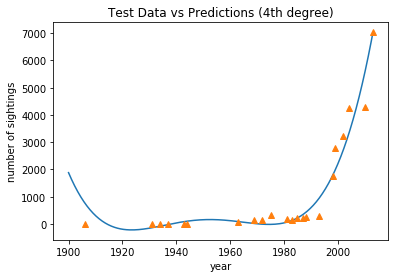

In [127]:
best_predictor = np.polyfit(train_x,train_y, 4)
best_polynomial = np.poly1d(best_predictor)

#recall that:
x_vals = np.linspace(1900,2013,200)
best_predictions = best_polynomial(x_vals)

plt.plot(x_vals, best_predictions)
plt.plot(test['year'],test['number of sightings'],'^')
plt.title("Test Data vs Predictions (4th degree)")
plt.xlabel("year")
plt.ylabel("number of sightings")
#Find the square root of the average squared error.
test_error = np.sqrt( np.mean( (test['number of sightings'] - best_polynomial(test['year']))**2 ) )
print("Test Error: " + str(test_error))

The test error of 464.9 means that on average, our predictor is off by about 465 UFO sightings each year. However in the graph it is apparent that it is vastly over estimating the number of UFO's before 1920. For this reason I will switch back to a 3rd degree polynomial which better ressembles the distribution. 


Test Error: 575.959006821


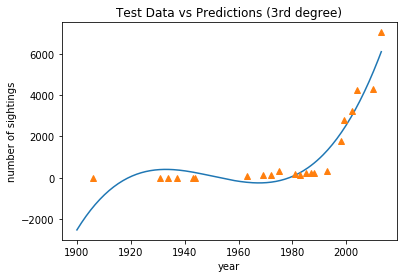

In [128]:
best_predictor2 = np.polyfit(train_x,train_y, 3)
best_polynomial2 = np.poly1d(best_predictor2)

#recall that:
x_vals = np.linspace(1900,2013,200)
best_predictions2 = best_polynomial2(x_vals)

plt.plot(x_vals, best_predictions2)
plt.plot(test['year'],test['number of sightings'],'^')
plt.title("Test Data vs Predictions (3rd degree)")
plt.xlabel("year")
plt.ylabel("number of sightings")
#Find the square root of the average squared error.
test_error = np.sqrt( np.mean( (test['number of sightings'] - best_polynomial2(test['year']))**2 ) )
print("Test Error: " + str(test_error))

Here it becomes clear that even though the distribution decreases as it approaches the origin, it is not a better fit. The model drops below -2000, which as we know is impossible. Also the rest of the data is fit poorly. Because of this, we will stick to using the 4th degree polynomial.
##### Hypothesis Testing
Now it is up to us to test our hypothesis that we can predict the number of UFO sightings given the year. We will approximate the accuracy of our hypothesis with an [R-Squared score](http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit). In short, an R-squared score is a value between 0 and 1 that measures how close the data is fitted to the polyfit line that we created\*.  The closer the score is to 1, the better fitted the data is to the polyfit line. 

\*R-squared scores can also be used for any sort of [regression](https://en.wikipedia.org/wiki/Regression_analysis).

In [31]:
sklearn.metrics.r2_score(test['number of sightings'],best_polynomial(test['year']))

0.92727445852339374

This a great R2 score and nearly confirms our hypothesis. However R2 score is not a definitive answer. Indeed, our polyfit line is highly innaccurate before the 1920's. While this disproves our hypothesis, the high R2 score and the visual evidence of fittedness suggest a corallary hypothesis that we can accurately estimate the number of UFO sightings per year *after* 1920.
##### Try it Out!
This corallary hypothesis  can easily be tested in the same way. All you have to do is remove the rows dating before 1920 and repeat the analysis.
##### Conclusion
While our hypothesis may not have been sound proof, this analysis has taught us much about UFOs. We learned that reported UFO sightings are far more common in the late hours and extremely early hours of the day, suggesting that it is best to go out UFO spotting when it is late, particularly between 7 pm and Midnight. We also learned that reports come in unsteadily rather than at a constant rate, suggesting that one reported UFO sighting can cause many others to come in. Additionally we learned that reported UFO sightings have greatly increased over time, suggesting that historical events and attitudes may have impacted the number of reported UFOs. 

We also learned how to utilize python to convert massive datasets into readable forms, how to analyze these forms, and how to test our hypotheses. It is my hope that you will take these skills and use them to discover many other interesting trends.

##### References
* Anaconda https://www.continuum.io
* sklearn user guide http://scikit-learn.org/stable/user_guide.html#user-guide
* Pandas API https://pandas.pydata.org/pandas-docs/stable/api.html
* Matplotlib API(includes pyplot) http://matplotlib.org/api/index.html
* Numpy.polyfit https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
* Lambda functions in python https://www.python-course.eu/python3_lambda.php
* Helpful tutorial by J. Miguel and A Kuriacose https://jonsm.github.io/
* regular expressions tutorial https://www.tutorialspoint.com/python/python_reg_expressions.htm
